

# 📝 Portfolio_Project (강구성)
---

# 넷플릭스 데이터셋을 활용한 추천시스템


In [ ]:
!pip install shap
!pip install pdpbox
# Google Colab으로 수행한다면 이 셀을 먼저 실행해주세요

import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

!pip install eli5
!pip install category_encoders     ##매번 작업할때마다 설치해줘야한다...
!pip install -U pandas-profiling 
!pip install -U scikit-learn
from pandas_profiling import ProfileReport
from category_encoders import OneHotEncoder
from category_encoders import TargetEncoder
from category_encoders import OrdinalEncoder

from sklearn.pipeline import Pipeline #make_pipeline과의 차이를 알아둘 것
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import OrdinalEncoder #float type을 제외한 다른 타입 전부 변환 *사용주의*
from sklearn.feature_selection import f_regression, SelectKBest
from scipy.stats import randint, uniform

import eli5
from eli5.sklearn import PermutationImportance

Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.11.0)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.24.1)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.font_manager
import matplotlib.pyplot as plt
from pdpbox import pdp
import seaborn as sns
import pandas as pd
import numpy as np
np.seterr(divide='ignore', invalid='ignore') # (참고) warning 제거를 위한 코드

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [ ]:


path = '/content/netflix_titles.csv'

df = pd.read_csv(path)

# 데이터셋이 잘 불러졌는지 확인합니다
#assert df.shape == (7787, 12)

In [ ]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [ ]:
df.shape #데이터프레임 행렬 수 확인

(7787, 12)

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df.isnull().sum() #각 특성별 결측지 총합계

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

In [ ]:
df.dtypes #칼럼별 밸류 유형 확인

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

In [ ]:
df.nunique() #각 칼럼별 카테고리 종류 수

show_id         7787
type               2
title           7787
director        4049
cast            6831
country          681
date_added      1565
release_year      73
rating            14
duration         216
listed_in        492
description     7769
dtype: int64

In [ ]:
movies = df[df.type == 'Movie'] #Target 특성 정하기 'type' 사용
shows = df[df.type == 'TV Show']

In [ ]:
movies['release_year'].unique() # 영화 장르 출시 연도 리스트화 하기

array([2016, 2011, 2009, 2008, 2019, 1997, 2017, 2018, 2014, 2015, 2020,
       2010, 2005, 2012, 2006, 2013, 2000, 2003, 1989, 2004, 1977, 1971,
       1993, 2007, 1998, 1988, 1996, 2002, 1986, 1990, 1979, 1980, 1974,
       2001, 1999, 1966, 1991, 1982, 1994, 1995, 1978, 1992, 1972, 1975,
       1973, 1967, 1960, 1981, 1958, 1976, 2021, 1968, 1956, 1985, 1965,
       1984, 1983, 1987, 1945, 1946, 1962, 1942, 1969, 1955, 1963, 1964,
       1954, 1970, 1944, 1947, 1959, 1943])

In [ ]:
shows['release_year'].unique() # 티비쇼 장르 출시 연도 리스트화 하기

array([2020, 2016, 2018, 2019, 2013, 2017, 2014, 2006, 2010, 2015, 2012,
       2011, 2003, 2009, 2007, 2001, 1997, 2021, 1991, 2005, 1999, 1992,
       1994, 2008, 1977, 2002, 1979, 1998, 1988, 1990, 1996, 2004, 2000,
       1972, 1974, 1995, 1981, 1946, 1925, 1985, 1986, 1968, 1993, 1967,
       1989, 1963])

In [ ]:
df.info() #feature 별 결측지 수 및 Dtype 살펴보기

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [ ]:
# 타겟을 정합니다
# type => 0 == TV show, 1 == Movie
target = 'type' #타겟은 shows or movies 인지를 나타내주는 'type' 사용, 나머지 특성들을 사용해 방송장르와의 상관관계를 확인하여 다른 새로운 데이터가 들어왔을 시 어떤 장르일지를 예측해 보는 모델을 만들 예정
features = df.drop('type', axis=1)

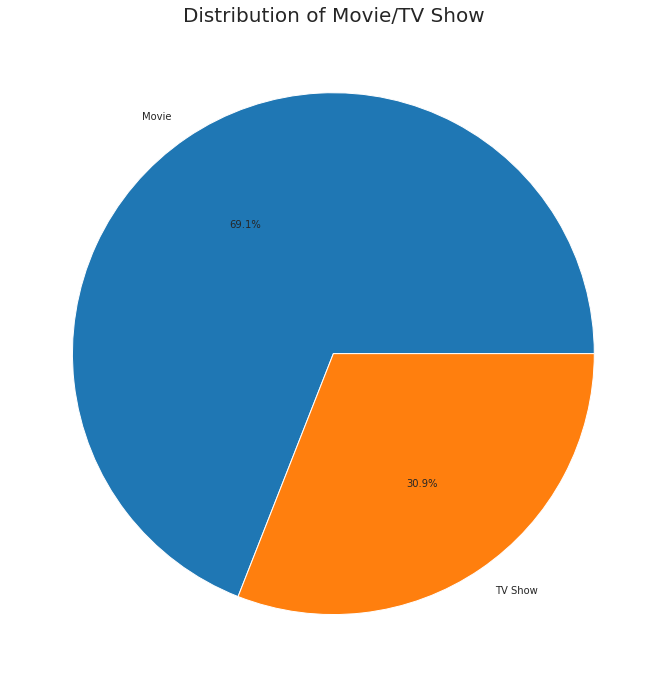

In [ ]:
#target을 show or moview 라는 범주형으로 두 카테고리 중 하나로 정해지는 모델을 만들 예정이기에 분류문제로 구분함.
bar, ax = plt.subplots(figsize = (12,12))
plt.pie(df['type'].value_counts(), labels = df['type'].value_counts().index, autopct="%.1f%%")
plt.title('Distribution of Movie/TV Show', size=20);
#다수 클래스(majority class) 비율이 50%~70% 범위 안에 밸런스를 유지하고 있음

In [ ]:
#분류문제를 풀기전 타겟범주가 어떤 비율을 가지고 있는지 확인
y_df = df[target]
y_df.value_counts(normalize=True)


Movie      0.69051
TV Show    0.30949
Name: type, dtype: float64

In [ ]:
pd.unique(df['type'])

array(['TV Show', 'Movie'], dtype=object)

In [ ]:
df['type'] = df['type'].replace('TV Show', '0')
df['type'] = df['type'].replace('Movie', '1')

In [ ]:
df['type']

0       0
1       1
2       1
3       1
4       1
       ..
7782    1
7783    1
7784    1
7785    0
7786    1
Name: type, Length: 7787, dtype: object

In [ ]:
df['type'].astype(int)

0       0
1       1
2       1
3       1
4       1
       ..
7782    1
7783    1
7784    1
7785    0
7786    1
Name: type, Length: 7787, dtype: int64

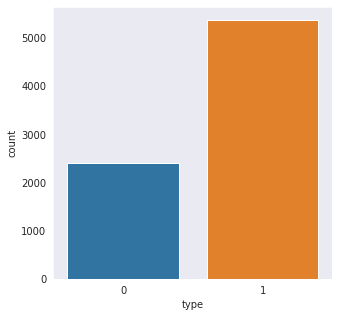

In [ ]:
plt.rcParams["figure.figsize"] = (5,5) #시각화
sns.countplot(x=df[target]);

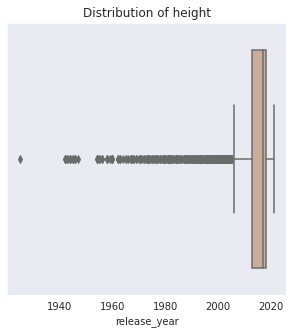

In [ ]:
#한 눈에 봐서 볼 수 있게 시각화하여 아웃라이어의 기준을 정해보기

sns.set_style('dark')
sns.boxplot(df.release_year,palette='pink')
plt.title('Distribution of height');

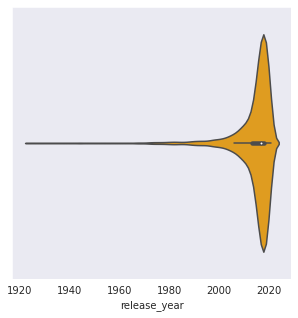

In [ ]:
sns.violinplot(df.release_year,color='orange'); #개봉시기를 시각화하여 아웃라이어를 파악하고 이를 제거하기

In [ ]:
## 타겟 이상치(outlier)를 제거합니다.
df = df.loc[df['release_year'] > 1950] 


In [ ]:
### 시간별로 데이터를 나눈다면 올바르게 학습할 수 없습니다. 한 구간의 연도에서 쇼나 영화가 대부분 개봉되었기 때문에 올바르게 학습하는 모델을 만들 수가 없습니다. 그렇기에 랜덤하게 학습데이터와 
#테스트데이터로 분할 하겠습니다.

In [ ]:
df['rating'].unique() #rating 결측지 처리하기

array(['TV-MA', 'R', 'PG-13', 'TV-14', 'TV-PG', 'NR', 'TV-G', 'TV-Y', nan,
       'TV-Y7', 'PG', 'G', 'NC-17', 'TV-Y7-FV', 'UR'], dtype=object)

In [ ]:
df[df['rating'].isna()] #'rating' column 기준 결측지있는 데이터 확인

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
67,s68,1,13TH: A Conversation with Oprah Winfrey & Ava ...,NaN,"Oprah Winfrey, Ava DuVernay",NaN,"January 26, 2017",2017,NaN,37 min,Movies,Oprah Winfrey sits down with director Ava DuVe...
2359,s2360,0,Gargantia on the Verdurous Planet,NaN,"Kaito Ishikawa, Hisako Kanemoto, Ai Kayano, Ka...",Japan,"December 1, 2016",2013,NaN,1 Season,"Anime Series, International TV Shows","After falling through a wormhole, a space-dwel..."
3660,s3661,0,Little Lunch,NaN,"Flynn Curry, Olivia Deeble, Madison Lu, Oisín ...",Australia,"February 1, 2018",2015,NaN,1 Season,"Kids' TV, TV Comedies","Adopting a child's perspective, this show take..."
3736,s3737,1,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,"April 4, 2017",2017,NaN,74 min,Movies,"Louis C.K. muses on religion, eternal love, gi..."
3737,s3738,1,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,"September 16, 2016",2010,NaN,84 min,Movies,Emmy-winning comedy writer Louis C.K. brings h...
3738,s3739,1,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,"August 15, 2016",2015,NaN,66 min,Movies,The comic puts his trademark hilarious/thought...
4323,s4324,1,My Honor Was Loyalty,Alessandro Pepe,"Leone Frisa, Paolo Vaccarino, Francesco Miglio...",Italy,"March 1, 2017",2015,NaN,115 min,Dramas,"Amid the chaos and horror of World War II, a c..."


In [ ]:
rating_replacements = {
    211: 'TV-14',
    2411: 'TV-14',
    3288: 'PG-13',
    4056: 'TV-G',
    4402: 'TV-G',
    4403: 'TV-G',
    4706: 'TV-14',
    5015: 'TV-14',
    5234: 'TV-14',
    6231: 'TV-Y'
}

for id, rate in rating_replacements.items():
    df.iloc[id, 8] = rate
    
df['rating'].isna().sum() #refer to amazon 사이트에서 rating 이름 알아내어 결측값에 대체

7

In [ ]:
df = df.drop(['director', 'cast','show_id', 'description', 'listed_in'], axis=1) #identification columns 제거해주기 #high cardinality 특성들도 제거해주기
df = df[df['date_added'].notna()] #date_added to Netlix 제거하기 11행밖에없고 이에 대한 자료를 찾을 수 가 없어서 수정하기
df.columns

Index(['type', 'title', 'country', 'date_added', 'release_year', 'rating',
       'duration'],
      dtype='object')

In [ ]:
df = df.set_index('title') #제목을 인덱스로 셋팅

In [ ]:
df['country'] = df['country'].fillna(df['country'].mode()[0]) #country missing value 채워주기

In [ ]:
df.isna().sum() #결측지 최종 확인

type            0
country         0
date_added      0
release_year    0
rating          7
duration        0
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df.shape

(7755, 6)

In [ ]:
ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
} #관람최소연령 기준을 가지고 새로운 특성 생성

In [ ]:
df['target_ages'] = df['rating'].replace(ratings_ages)#관람등급별 연령 기준으로 새 특성 생성
df['target_ages'].unique()

array(['Adults', 'Teens', 'Older Kids', 'Kids'], dtype=object)

In [ ]:
# 하나의 데이터에 여러나라가 포함되었던 country라는 특성에서 맨 앞의 한개의 나라만을 따서 새로운 특성 'principal country' == '주요한 나라'라는 특성 생성
df['principal_country'] = df['country'].apply(lambda x: x.split(",")[0])
df['principal_country'].head()

title
3%              Brazil
7:19            Mexico
23:59        Singapore
9        United States
21       United States
Name: principal_country, dtype: object

In [ ]:
df['principal_country']

title
3%                                                 Brazil
7:19                                               Mexico
23:59                                           Singapore
9                                           United States
21                                          United States
                                                ...      
Zozo                                               Sweden
Zubaan                                              India
Zulu Man in Japan                           United States
Zumbo's Just Desserts                           Australia
ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS    United Kingdom
Name: principal_country, Length: 7755, dtype: object

In [ ]:
import plotly.express as px
country_df = df['principal_country'].value_counts().reset_index()
country_df = country_df[country_df['principal_country'] /  country_df['principal_country'].sum() > 0.01]

fig = px.pie(country_df, values='principal_country', names='index')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show(); #주요 나라별 영상 분포 시각화

In [ ]:
fig = px.histogram(df, x='principal_country')
fig.update_xaxes(categoryorder='total descending')
fig.show()#히스토그램으로 주요 나라별 영상 분포 시각화

In [ ]:
df['duration'].value_counts() # high cardinality feature 제거

1 Season     1604
2 Seasons     378
3 Seasons     183
90 min        136
93 min        131
             ... 
203 min         1
200 min         1
205 min         1
204 min         1
5 min           1
Name: duration, Length: 215, dtype: int64

In [ ]:
df['year_added'] = df['date_added'].apply(lambda x: x.split(" ")[-1])
df['year_added'].head() #년도와 달을 나누어서 어떤 기간과 더 연관성이 있는지를 좀더 쉽게 구분하기위하여 나누어주겠습니다.

title
3%       2020
7:19     2016
23:59    2018
9        2017
21       2020
Name: year_added, dtype: object

In [ ]:
df['month_added'] = df['date_added'].apply(lambda x: x.split(" ")[0])
df['month_added'].head()

title
3%         August
7:19     December
23:59    December
9        November
21        January
Name: month_added, dtype: object

In [ ]:
# target aged 데이터 타입을 category로 변환
df['target_ages'] = pd.Categorical(df['target_ages'], categories=['Kids', 'Older Kids', 'Teens', 'Adults'])

# year added 특성의 타입을 int로 변환 released year 특성과 비교를 위함.
df['year_added'] = pd.to_numeric(df['year_added'])

In [ ]:
df = df.drop(['date_added','country', 'duration'], axis=1) #high cardinality feature 제거 및 새로운 특성을 만드는데 사용한 특성들 제거

In [ ]:
df.info() #전처리 끝난 데이터 확인, 결측지 없음.

<class 'pandas.core.frame.DataFrame'>
Index: 7755 entries, 3% to ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               7755 non-null   object  
 1   release_year       7755 non-null   int64   
 2   rating             7755 non-null   object  
 3   target_ages        7755 non-null   category
 4   principal_country  7755 non-null   object  
 5   year_added         7755 non-null   int64   
 6   month_added        7755 non-null   object  
dtypes: category(1), int64(2), object(4)
memory usage: 751.9+ KB


## 2) Xgboost 모델링 후 기존모델과 비교


### 1) 간단한 모델을만들어 학습시킨 경우


In [ ]:
###트레인 데이터와 테스트 데이터로, 8:2 비율로 랜덤하게 분할하겠습니다
from sklearn.model_selection import train_test_split
train, val = train_test_split(df, test_size=0.2, random_state=2)
train.shape, val.shape

((6204, 7), (1551, 7))

In [ ]:
target = 'type'
features = df.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [ ]:
X_train.isnull().sum()

release_year         0
rating               0
target_ages          0
principal_country    0
year_added           0
month_added          0
dtype: int64

In [ ]:
#from sklearn.tree import DecisionTreeClassifier ## 랜덤포레스트크래시피어 사용할것이기에 이건 필요없음..
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(), 
     RandomForestClassifier(class_weight='balanced', random_state=2) #max_depth=5,를 안주고 default 값이 전체 leaf 로 계산하는 모델 사용 사용시 오히려 precision과 recall의 밸런스나 점수가 떨어짐
#    RandomForestClassifier(max_depth=5, class_weight={False:custom[0],True:custom[1]}, random_state=2)
)
### class_weight 의 balnace 조절을 하고 학습한 모델

pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

검증 정확도:  0.7459703417150225


In [ ]:
from sklearn.metrics import classification_report
y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred)) #Class_weight로 타겟 클래스 비중을 균형있게 만들지 않은 모델의 지표(Metric) 살펴보기

              precision    recall  f1-score   support

           0       0.59      0.62      0.60       481
           1       0.82      0.80      0.81      1070

    accuracy                           0.75      1551
   macro avg       0.70      0.71      0.71      1551
weighted avg       0.75      0.75      0.75      1551



### 2) Xgboost 를 사용한 모델

In [ ]:
vc = y_train.value_counts().tolist()
vc

[4289, 1915]

In [ ]:
# sum(negative instances) / sum(positive instances)
ratio = float(vc[0]/vc[1])
ratio

2.239686684073107

In [ ]:
from xgboost import XGBClassifier
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)


boosting = XGBClassifier(
    n_estimators=1000,  # <= 1000 트리로 설정했지만, early stopping 에 따라 조절됩니다.
    max_depth=7,        # default=3, high cardinality 특성을 위해 기본보다 높여 보았습니다.
    learning_rate=0.2,
     scale_pos_weight=ratio, # imbalance 데이터 일 경우 비율을 적용합니다.
    n_jobs=-1
)
####################################################xgb부스터는 simpleimputer를 기본제공하기에 인코딩 된 데이터값만 쓰여도 됨
eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

boosting.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='error', # #(wrong cases)/#(all cases)
          early_stopping_rounds=50
         ) # 50 rounds 동안 스코어의 개선이 없으면 멈춤

[0]	validation_0-error:0.259994	validation_1-error:0.281109
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.257415	validation_1-error:0.274662
[2]	validation_0-error:0.257737	validation_1-error:0.271438
[3]	validation_0-error:0.257092	validation_1-error:0.272083
[4]	validation_0-error:0.254674	validation_1-error:0.272083
[5]	validation_0-error:0.255642	validation_1-error:0.273372
[6]	validation_0-error:0.252257	validation_1-error:0.272727
[7]	validation_0-error:0.249355	validation_1-error:0.272083
[8]	validation_0-error:0.248388	validation_1-error:0.268214
[9]	validation_0-error:0.245487	validation_1-error:0.263056
[10]	validation_0-error:0.245326	validation_1-error:0.260477
[11]	validation_0-error:0.248549	validation_1-error:0.263056
[12]	validation_0-error:0.244036	validation_1-error:0.261122
[13]	validation_0-error:0.23775	validation_1-error:0.259

XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=1000, n_jobs=-1,
              scale_pos_weight=2.239686684073107)

In [ ]:
print('검증 정확도', boosting.score(X_val_encoded, y_val))

print(classification_report(y_val, boosting.predict(X_val_encoded)))


검증 정확도 0.7691811734364926
              precision    recall  f1-score   support

           0       0.72      0.42      0.53       481
           1       0.78      0.93      0.85      1070

    accuracy                           0.77      1551
   macro avg       0.75      0.67      0.69      1551
weighted avg       0.76      0.77      0.75      1551



## 3) Permutation importances를 계산하고 다른 중요도 결과와 비교해 보세요

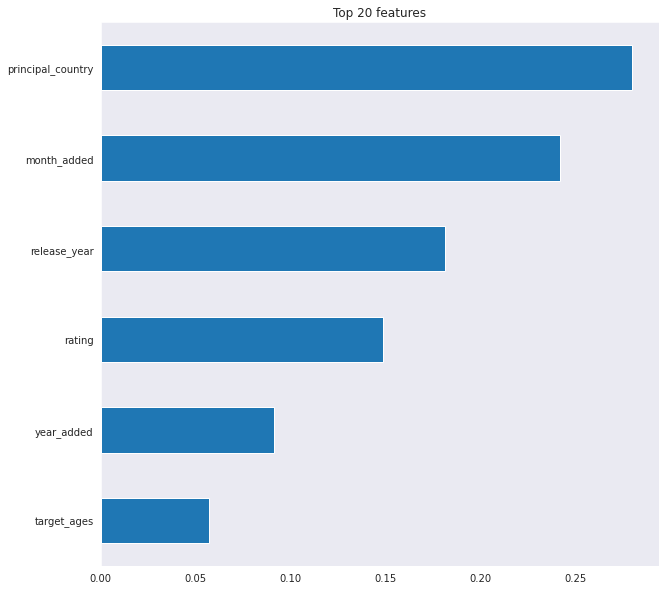

In [ ]:
# 특성 중요도
rf = pipe.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [ ]:
# pipeline 생성을 확인합니다.
pipe.named_steps

{'ordinalencoder': OrdinalEncoder(cols=['rating', 'target_ages', 'principal_country',
                      'month_added'],
                mapping=[{'col': 'rating', 'data_type': dtype('O'),
                          'mapping': TV-MA        1
 TV-PG        2
 TV-14        3
 R            4
 TV-Y7        5
 TV-Y         6
 UR           7
 NR           8
 PG-13        9
 TV-G        10
 G           11
 PG          12
 TV-Y7-FV    13
 NC-17       14
 NaN         -2
 dtype: int64},
                         {'col': 'target_ages',
                          'data_type': CategoricalDtype(categories=['Kids', 'Older Kids', 'Teens', 'Adults'], ordered=False),
                          'mapping...
 Kids          4
 NaN          -2
 dtype: int64},
                         {'col': 'principal_country', 'data_type': dtype('O'),
                          'mapping': Japan             1
 Canada            2
 Lebanon           3
 United States     4
 India             5
                  ..
 Hungary     

In [ ]:
from sklearn.pipeline import Pipeline
# encoder, imputer를 preprocessing으로 묶었습니다. 후에 eli5 permutation 계산에 사용합니다
pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())), ###인코더와 임퓨터를 모두 묶어서 'preprocessing'이라고 이름을 명명함.
    ('rf', RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=2, n_jobs=-1))  ### 모델종류는 'rf'라고 명명.# max_depth=5, 이것을 안주고 전체 leaf계산(defualt 값)
])


pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

검증 정확도:  0.7459703417150225


In [ ]:
#!pip install eli5
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    pipe.named_steps['rf'], # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val_transformed = pipe.named_steps['preprocessing'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_transformed, y_val);

In [ ]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

target_ages          0.015861
year_added           0.016248
month_added          0.020632
release_year         0.072211
rating               0.072211
principal_country    0.078917
dtype: float64

In [ ]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0789 ± 0.0079,principal_country
0.0722 ± 0.0124,rating
0.0722 ± 0.0326,release_year
0.0206 ± 0.0157,month_added
0.0162 ± 0.0145,year_added
0.0159 ± 0.0092,target_ages


결과 판단:
순열 중요도를 확인한 결과 'principla_country', 'rating', 'realease_year' 세 특성이 나머지 세 특성에 비하여 더 중요도가 높게 나왔다. 특성 중요도에서는 month added가 2순위이고 release_year는 3순위로 같고 4순위는 rating이 나와서 순열 중요도 결과와는 차이가 있었다.

### 2) PDP를 만들어 모델을 설명하세요
- 한 특성에 대한 PDP를 만들고 모델을 설명하세요
- 두 특성간 관계에 대한 PDP를 만들고 모델을 설명하세요


1) 한 특성을 이용한 PDP 시각화 및 모델 설명

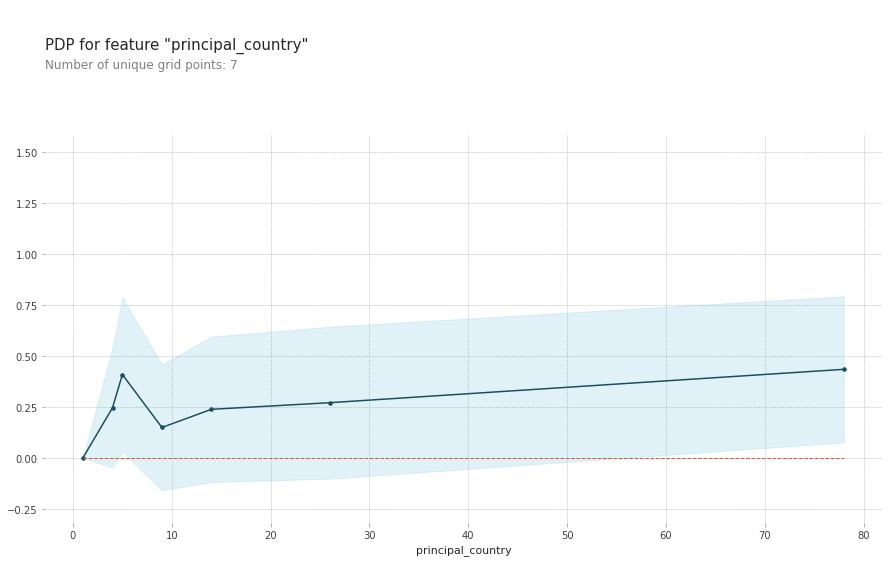

In [ ]:
import matplotlib.font_manager
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'principal_country'
pdp_dist = pdp.pdp_isolate(model=boosting, dataset=X_train_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature); # 인코딩된 sex 값을 확인할 수 있습니다

In [ ]:
# encoder 맵핑을 확인합니다, {male:1, female:2} 로 인코딩 되어 있습니다
encoder.mapping

[{'col': 'rating', 'data_type': dtype('O'), 'mapping': TV-MA        1
  TV-PG        2
  TV-14        3
  R            4
  TV-Y7        5
  TV-Y         6
  UR           7
  NR           8
  PG-13        9
  TV-G        10
  G           11
  PG          12
  TV-Y7-FV    13
  NC-17       14
  NaN         -2
  dtype: int64},
 {'col': 'target_ages',
  'data_type': CategoricalDtype(categories=['Kids', 'Older Kids', 'Teens', 'Adults'], ordered=False),
  'mapping': Adults        1
  Older Kids    2
  Teens         3
  Kids          4
  NaN          -2
  dtype: int64},
 {'col': 'principal_country',
  'data_type': dtype('O'),
  'mapping': Japan             1
  Canada            2
  Lebanon           3
  United States     4
  India             5
                   ..
  Hungary          75
  Iran             76
  Slovenia         77
  Guatemala        78
  NaN              -2
  Length: 79, dtype: int64},
 {'col': 'month_added', 'data_type': dtype('O'), 'mapping': June          1
  November      

In [ ]:
# 이번에는 PDP 카테고리값 맵핑을 자동으로 해보겠습니다

feature = 'principal_country'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping'] # Series
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

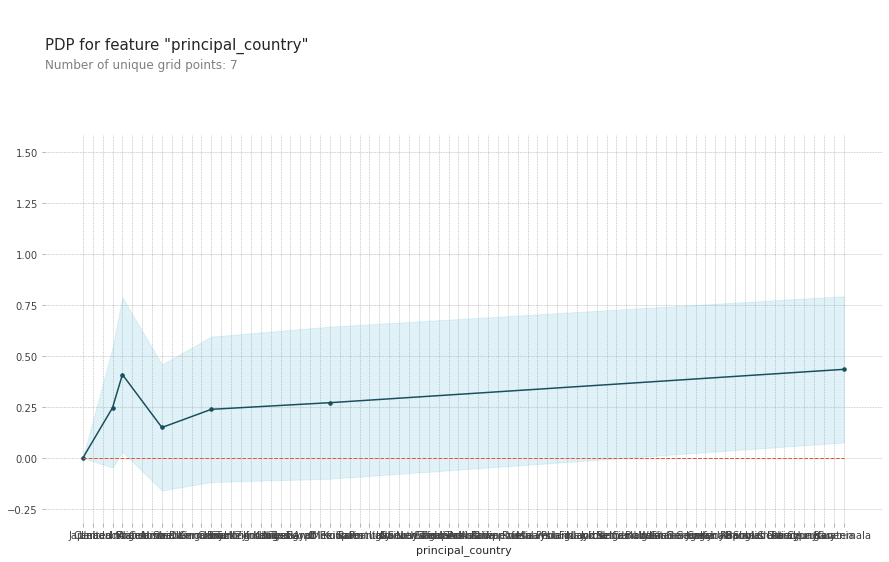

In [ ]:
pdp.pdp_plot(pdp_dist, feature)

# xticks labels 설정을 위한 리스트를 직접 넣지 않아도 됩니다 
plt.xticks(category_codes, category_names);

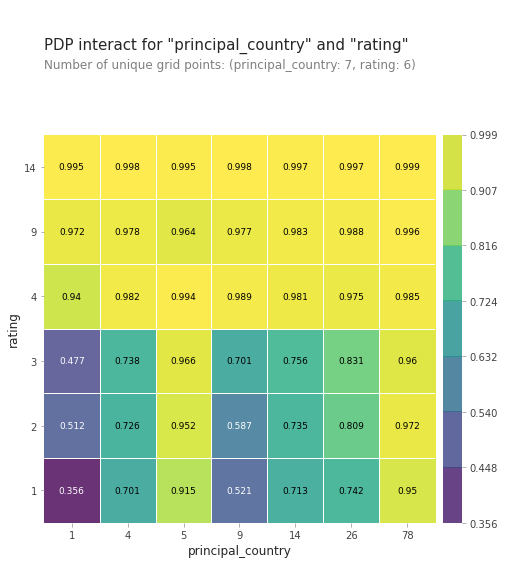

In [ ]:
# 2D PDP
import matplotlib.font_manager
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['principal_country', 'rating']

interaction = pdp_interact(
    model=boosting, 
    dataset=X_train_encoded, 
    model_features=X_train.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

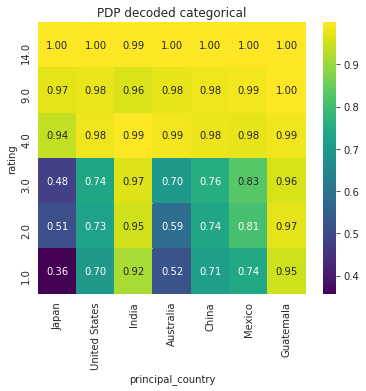

In [ ]:
# 2D PDP 를 Seaborn Heatmap으로 그리기 위해 데이터프레임으로 만듭니다
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1]

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(6,5))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('PDP decoded categorical');

In [ ]:
#3D 시각화
features

['principal_country', 'rating']

In [ ]:
# 2D PDP dataframe
interaction.pdp

,principal_country,rating,preds
0,1.0,1.0,0.356077
1,1.0,2.0,0.511800
2,1.0,3.0,0.477107
3,1.0,4.0,0.939834
4,1.0,9.0,0.972302
5,1.0,14.0,0.995444
6,4.0,1.0,0.700839
7,4.0,2.0,0.726206
8,4.0,3.0,0.737931
9,4.0,4.0,0.982202


In [ ]:
type(interaction.pdp)

pandas.core.frame.DataFrame

In [ ]:
# 위에서 만든 2D PDP를 테이블로 변환(using Pandas, df.pivot_table)하여 사용합니다

pdp = interaction.pdp.pivot_table(
    values='preds', # interaction['preds']
    columns=features[0], 
    index=features[1]
)[::-1] # 인덱스를 역순으로 만드는 slicing입니다

In [ ]:
pdp

principal_country,1.0,4.0,5.0,9.0,14.0,26.0,78.0
rating,,,,,,,
14.0,0.995444,0.997786,0.994690,0.997805,0.996601,0.997377,0.999337
9.0,0.972302,0.977843,0.963573,0.976603,0.983369,0.987572,0.995675
4.0,0.939834,0.982202,0.994340,0.988649,0.980843,0.975253,0.985020
3.0,0.477107,0.737931,0.966487,0.701109,0.755502,0.830855,0.959884
2.0,0.511800,0.726206,0.952243,0.587123,0.735149,0.808752,0.971848
1.0,0.356077,0.700839,0.915387,0.521409,0.712914,0.741528,0.950135


In [ ]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()

### 3) SHAP 라이브러리를 사용해 최소 3개 이상 시각화를 하고 분석하세요

In [ ]:
def explain(row_number):
    positive_class = 'Movie'
    positive_class_index = 1

    # row 값을 변환합니다
    row = X_val.iloc[[row_number]]
    row_processed = encoder.transform(row)

    # 예측하고 예측확률을 얻습니다 
    pred = boosting.predict(row_processed)[0]
    pred_proba = boosting.predict_proba(row_processed)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba

    # 예측결과와 확률값을 얻습니다
    print(f'이 유저의 movie 선호도에 대한 예측결과는 {pred} 으로, 확률은 {pred_proba:.0f}% 입니다.')
    
    # SHAP를 추가합니다
    shap_values = explainer.shap_values(row_processed)

    # Fully Paid에 대한 top 3 pros, cons를 얻습니다
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    # 예측에 가장 영향을 준 top3
    print('\n')
    print('Positive 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # 예측에 가장 반대적인 영향을 준 요인 top1
    print('\n')
    print('Negative 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = cons if pred == positive_class else pros
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # SHAP
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row, 
        link='logit'
    )

In [ ]:
# 테스트셋에서 인덱스 1 샘플의 예측을 살펴보겠습니다.
# 우선 모든 특성 수치를 봅시다
row = X_val.iloc[[154]]
row

,release_year,rating,target_ages,principal_country,year_added,month_added
title,,,,,,
El Chapo,2018,TV-MA,Adults,Mexico,2018,July


In [ ]:
## UnicodeDecoderError 발생시 xgboost 1.1-> 1.0 다운그레이드 (conda install -c conda-forge xgboost=1.0)
import xgboost
import shap

explainer = shap.TreeExplainer(boosting)
row_processed = encoder.transform(row) # row 를 X_train이나 X_val 혹은 X_test로 할 수도 있으나 그러면 한 행이 아닌데...
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

In [ ]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

In [ ]:
feature_values

array([2018, 'TV-MA', 'Adults', 'Mexico', 2018, 'July'], dtype=object)

In [ ]:
feature_names

Index(['release_year', 'rating', 'target_ages', 'principal_country',
       'year_added', 'month_added'],
      dtype='object')

In [ ]:
from sklearn.metrics import roc_auc_score
class_index = 1
y_pred_proba = boosting.predict_proba(X_val_encoded)[:, class_index]
print(f'Test AUC for class "{boosting.classes_[class_index]}":')
print(roc_auc_score(y_val, y_pred_proba)) # 범위는 0-1, 수치는 높을 수록 좋습니다

Test AUC for class "1":
0.8355800804398936


In [ ]:
pros = shaps.sort_values(ascending=False)[:3].index
cons = shaps.sort_values(ascending=True)[:3].index

In [ ]:
print('Movie 예측에 대한 Positive 요인 Top 3 입니다:')
for i, pro in enumerate(pros, start=1):
    feature_name, feature_value = pro
    print(f'{i}. {feature_name} : {feature_value}')

print('\n')
print('Negative 요인 Top 3 입니다:')
for i, con in enumerate(cons, start=1):
    feature_name, feature_value = con
    print(f'{i}. {feature_name} : {feature_value}')

Movie 예측에 대한 Positive 요인 Top 3 입니다:
1. target_ages : Adults
2. principal_country : Mexico
3. year_added : 2018


Negative 요인 Top 3 입니다:
1. rating : TV-MA
2. month_added : July
3. release_year : 2018


In [ ]:
explain(217) # 해당 설명과 맞는 샘플 골라서 넣어줘야함

이 유저의 movie 선호도에 대한 예측결과는 1 으로, 확률은 46% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. release_year : 2020
2. rating : TV-MA
3. month_added : January


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. target_ages : Adults
2. year_added : 2020
3. principal_country : United States


In [ ]:
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [ ]:
# test ids를 저장하고 SHAP분석시 사용합니다 ## 이 부분 다시 살펴 볼 것
test_id = X_val['release_year']

In [ ]:
df_p = pd.DataFrame({
    'release_year': test_id, 
    'pred_proba': y_pred_proba, # 예측확률 
    'status_group': y_val # 실제값
})

# = df_p.merge(
#     X_val[['release_year', 'rating', 'target_ages', 'principal_country', 'year_added', 'month_added']],
#     how='left'
#)

In [ ]:
X_val['release_year']

0       2016
1       2015
2       2019
3       2018
4       2016
        ... 
1546    2020
1547    2009
1548    2020
1549    2018
1550    2019
Name: release_year, Length: 1551, dtype: int64

In [ ]:
y_val

0       1
1       1
2       0
3       1
4       1
       ..
1546    0
1547    0
1548    0
1549    1
1550    0
Name: type, Length: 1551, dtype: object

In [ ]:
pd.DataFrame(y_pred_proba)

,0
0,0.997730
1,0.999890
2,0.354556
3,0.703629
4,0.650787
...,...
1546,0.944088
1547,0.000289
1548,0.574675
1549,0.422235


In [ ]:
df_p

,release_year,pred_proba,status_group
0,2016,0.997730,1
1,2015,0.999890,1
2,2019,0.354556,0
3,2018,0.703629,1
4,2016,0.650787,1
...,...,...,...
1546,2020,0.944088,0
1547,2009,0.000289,0
1548,2020,0.574675,0
1549,2018,0.422235,1


In [ ]:
df_p['status_group'] = df_p['status_group'].astype(int) #이부분이 int가 아니면 아래 코딩이 인식을 못하여 작동을 안함. 이 부분 주의할 것.

In [ ]:
movie = df_p['status_group'] == 1
show = ~movie
right = (movie) == (df_p['pred_proba'] > 0.50)
wrong = ~right

In [ ]:
df_p['status_group']


0       1
1       1
2       0
3       1
4       1
       ..
1546    0
1547    0
1548    0
1549    1
1550    0
Name: status_group, Length: 1551, dtype: int64

In [ ]:
right

0        True
1        True
2        True
3        True
4        True
        ...  
1546    False
1547     True
1548    False
1549    False
1550     True
Length: 1551, dtype: bool

In [ ]:
(movie).unique()

array([ True, False])

#### 실제 값은 영화선호 인데 , 예측값은 틀린 경우

In [ ]:
df_p[movie & wrong].sample(n=10, random_state=1).sort_values(by='pred_proba')

,release_year,pred_proba,status_group
960,2020,0.066456,1
1169,2018,0.138928,1
567,2020,0.172996,1
1291,2020,0.257442,1
1383,1994,0.271396,1
714,2019,0.303367,1
839,2019,0.335229,1
1028,2019,0.396274,1
1129,2020,0.401227,1
1549,2018,0.422235,1


In [ ]:
explain(1549) # 해당 설명과 맞는 샘플 골라서 넣어줘야함

이 유저의 movie 선호도에 대한 예측결과는 0 으로, 확률은 58% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. target_ages : Teens
2. year_added : 2018
3. principal_country : China


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. month_added : July
2. release_year : 2018
3. rating : TV-14


#### 선호도 결과는 show, 예측이 잘못된 경우

In [ ]:
df_p[show & wrong].sample(n=10, random_state=1).sort_values(by='pred_proba')

,release_year,pred_proba,status_group
320,2018,0.526371,0
1217,2015,0.567382,0
534,2018,0.616756,0
1001,2015,0.642047,0
656,2019,0.707345,0
1430,2019,0.733062,0
457,2020,0.745927,0
548,2018,0.815261,0
61,2013,0.883975,0
1243,2019,0.923099,0


In [ ]:
explain(1243) # 해당 설명과 맞는 샘플 골라서 넣어줘야함

이 유저의 movie 선호도에 대한 예측결과는 1 으로, 확률은 8% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. release_year : 2019
2. year_added : 2019
3. rating : TV-MA


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. principal_country : Spain
2. month_added : October
3. target_ages : Adults


### 결과는 show인데, 예측이 맞은 경우

In [ ]:
df_p[show & right].sample(n=10, random_state=1).sort_values(by='pred_proba')

,release_year,pred_proba,status_group
732,2019,0.004160,0
896,2018,0.020598,0
151,2014,0.046937,0
1145,2013,0.050453,0
605,2019,0.077625,0
1329,2005,0.165778,0
235,2018,0.201350,0
415,2016,0.271319,0
31,2007,0.495981,0
287,2008,0.499487,0


In [ ]:
explain(1329) # 해당 설명과 맞는 샘플 골라서 넣어줘야함

이 유저의 movie 선호도에 대한 예측결과는 0 으로, 확률은 83% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. principal_country : United States
2. release_year : 2005
3. rating : TV-PG


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. year_added : 2020
2. month_added : October
3. target_ages : Older Kids
